In [ ]:
##Loading libraries

import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


import pandas as pd

from torchvision import datasets
from torchvision import transforms

from torchvision import transforms

import torch.optim as optim

import random

import pickle

import copy

In [ ]:
path = 'saved_models'
import os
os.makedirs(path, exist_ok=True)

In [ ]:
!pip install medmnist
import medmnist
from medmnist import INFO, Evaluator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=42dacc7e07776c33ef6954ba2097ef90b6d4602af19fa91500c1982eb3774633
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


In [ ]:
from utils import *
from train import *
from test import *
from modelCNN import *

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


In [ ]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
torch.cuda.seed()

# Mnist or CIFAR 10


In [ ]:
dataset = "MNIST"

In [ ]:

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

batch_size_l = 72 
batch_size_u = 400
batch_size_t = 20
valid_perc = 0.1 #percentage for valid set
n_classes = 10

mecha = "MNAR"
compt_u = [400  ,517 , 667 , 862, 1113 ,1438 ,1857 ,2398 ,3097 ,4000] #[2000,2000,2000,2000,3000,3000,500,600,  200,300] #[4000, 3540, 3134, 2773, 2455, 2173, 1923, 1702, 1506, 1333]#[2000 ,1852, 1714, 1587 ,1470, 1361, 1260, 1167 ,1080 ,1000]#[50 ,32 ,21, 14, 9, 6, 4, 2 ,2, 1 ] #[4000, 3345, 2797, 2339, 1956, 1636 ,1368 ,1144 , 957 , 800]#[4000, 2398, 1438,  862 , 517 , 310  ,186  ,111   ,67 ,  40]#[400 ,310, 240 ,186 ,144 ,111 , 86  ,67 , 52 , 40] #[300  ,387 , 500 , 646,  835, 1078, 1392, 1798, 2323, 3000] #
compt = [400 ,310, 240, 186, 144 ,111 , 86 , 67 , 52 , 40]#[400 ,100 ,200, 50, 400 ,100 ,300 ,50 ,100, 300]#[800, 200 ,400 ,100 ,800 ,200 ,600 ,100 ,200 ,600]#[400 ,100 ,200, 50, 400 ,100 ,300 ,50 ,100, 300]#[3000,1636,2000,2444,1000,300,1500,1200,  1200, 2700]#[100, 114, 131, 149, 171, 195, 223, 255, 292, 333]#[2000, 2214, 2452 ,2714, 3005, 3327, 3684 ,4079, 4516, 5000] #None #[100 ,114, 131, 149, 171, 195, 223 ,255, 292, 333]
valid_num = 400

##### CIFAR10

if dataset == "CIFAR10":
    transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([125.3/ 255, 123.0/ 255, 113.9/ 255], [63.0/ 255, 62.1/ 255, 66.7/ 255])
      ])
    init_channel = 3

##### MNIST

if dataset == "MNIST":
    transform = transforms.Compose([
                transforms.ToTensor(), 
                transforms.Normalize((0.5,), (1.0,))])
    init_channel = 1

#########################
##### Load the data #####
#########################

##### CIFAR10

if dataset == "CIFAR10":
    train_data = datasets.CIFAR10('data', train=True,
                                download=True, transform=transform)
    test_data = datasets.CIFAR10('data', train=False,
                              download=True, transform=transform)

##### MNIST

if dataset == "MNIST":
    train_data = datasets.MNIST(root = "data",train = True,
                              download = True, transform = transform)
    test_data = datasets.MNIST(root = "data",train = False,
                            download = True, transform = transform)
    
if dataset == "CIFAR10":
  classes = ['plane', 'auto', 'bird', 'cat', 'deer',
            'dog', 'frog', 'horse', 'ship', 'truck']

if dataset == "MNIST":
  classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


labeled_idx, valid_idx, unlabeled_idx = sample_labeled_data(train_data.data,np.array(train_data.targets),compt,valid_num,10,compt_u)
train_idx = labeled_idx + unlabeled_idx

#######################
##### Dataloaders #####
#######################

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
labeled_sampler = SubsetRandomSampler(labeled_idx)
unlabeled_sampler = SubsetRandomSampler(unlabeled_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_u,
    sampler=train_sampler)
labeled_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_l,
    sampler=labeled_sampler)
unlabeled_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_u,
    sampler=unlabeled_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_l, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_t)

In [ ]:
compt = [0]*n_classes
for u in range(n_classes):
    for idx in labeled_idx: 
        if train_data.targets[idx]==u:
            compt[u]+=1

compt_un = [0]*n_classes
for u in range(n_classes):
    for idx in unlabeled_idx: 
        if train_data.targets[idx]==u:
            compt_un[u]+=1
prob_true = []
for u in range(n_classes):
    prob_true+=[round(compt[u]/(compt_un[u]+compt[u]),4)]

prob_true



[0.5, 0.3748, 0.2646, 0.1775, 0.1146, 0.0717, 0.0443, 0.0272, 0.0165, 0.0099]

''

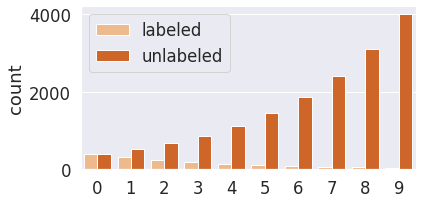

In [ ]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 6 , 3
sns.set(font_scale = 1.5)

plt.figure(figsize=(6 , 3))
y_u=[classes[train_data.targets[idx]] for idx in unlabeled_idx]
y_l=[classes[train_data.targets[idx]] for idx in labeled_idx]
y_val=[classes[train_data.targets[idx]] for idx in valid_idx]
y_plot=np.concatenate((y_l,y_u),axis=0)
r_plot=np.concatenate((np.repeat("labeled", len(y_l),axis=0),np.repeat("unlabeled", len(y_u),axis=0)),axis=0)
ax = sns.countplot(x=y_plot, hue=r_plot, palette = sns.color_palette("Oranges",n_colors=2),order=classes)
;

# medMNIST

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

batch_size_l = 63 #test 60 #64 (change 16/01)
batch_size_u = 128 #test 600 #128 (change 16/01)
batch_size_t = 20
valid_perc = 0.1 #percentage for valid set

mecha = "MNAR"

In [ ]:
data_flag = "dermamnist"
# data_flag = 'breastmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_data = DataClass(split='train', transform=data_transform, download=download)
test_data = DataClass(split='test', transform=data_transform, download=download)

  0%|          | 0/19725078 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/dermamnist.npz


In [ ]:
number_per_class = [0]*n_classes
for u in range(n_classes):
    for v in range(len(train_data.labels)):
        if train_data.labels[v]==u:
            number_per_class[u]+=1
number_per_class

[228, 359, 769, 80, 779, 4693, 99]

In [ ]:
number_per_class_test = [0]*n_classes
for u in range(n_classes):
    for v in range(len(test_data.labels)):
        if test_data.labels[v]==u:
            number_per_class_test[u]+=1
number_per_class_test
py_test=[number_per_class_test[u]/sum(number_per_class_test) for u in range(len(number_per_class_test))]

In [ ]:
compt = [70]*7#[100,250,500,40,550,2000,50]
#compt = [int(number_per_class[u]*0.3) for u in range(n_classes)] ##MCAR

In [ ]:
valid_num = 9*n_classes

labeled_idx, valid_idx, unlabeled_idx = sample_labeled_data(train_data.imgs,np.array(train_data.labels),compt,valid_num,n_classes,py=py_test)#,compt_u)
train_idx = labeled_idx + unlabeled_idx

#######################
##### Dataloaders #####
#######################

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
labeled_sampler = SubsetRandomSampler(labeled_idx)
unlabeled_sampler = SubsetRandomSampler(unlabeled_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_u,
    sampler=train_sampler)
labeled_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_l,
    sampler=labeled_sampler)
unlabeled_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_u,
    sampler=unlabeled_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size_l, 
    sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_t)

In [ ]:
prob_true = []
for u in range(n_classes):
    prob_true+=[round(compt[u]/(compt_un[u]+compt[u]),4)]

prob_true



[0.3097, 0.1966, 0.0917, 0.875, 0.0907, 0.0151, 0.7071]

In [ ]:
classes = ['0', '1', '2', '3', '4', '5', '6']

''

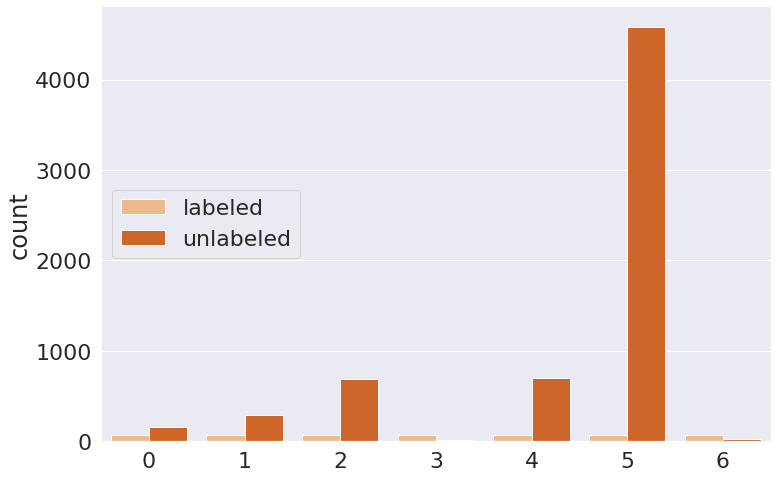

In [ ]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 10, 5
sns.set(font_scale = 2)

plt.figure(figsize=(12,8))
y_u=[classes[train_data.labels[idx][0]] for idx in unlabeled_idx]
y_l=[classes[train_data.labels[idx][0]] for idx in labeled_idx]
y_val=[classes[train_data.labels[idx][0]] for idx in valid_idx]
y_plot=np.concatenate((y_l,y_u),axis=0)
r_plot=np.concatenate((np.repeat("labeled", len(y_l),axis=0),np.repeat("unlabeled", len(y_u),axis=0)),axis=0)
ax = sns.countplot(x=y_plot, hue=r_plot, palette = sns.color_palette("Oranges",n_colors=2),order=classes)
;

# Model initialization

In [ ]:
###CHOOSE YOUR MODEL
model_init = medNet(n_channels, n_classes)
model = Net()
model_init = get_weights_copy(model_init,'model_init')

In [ ]:
print('Size of the train set:', len(unlabeled_idx)+len(labeled_idx))
print('Size of the labeled set:', len(labeled_sampler))
print('Size of the unlabeled set:', len(unlabeled_sampler))
print('Size of the valid set:', len(valid_idx))
print('Size of the test set:', len(test_data))

perc_lab = len(labeled_sampler)/(len(unlabeled_idx)+len(labeled_idx))
print('Percentage of labeled data:', perc_lab)

n_glob = len(labeled_idx)+len(unlabeled_idx) #-len(valid_idx)
nl_glob = len(labeled_sampler)
nu_glob = len(unlabeled_idx)

Size of the train set: 17985
Size of the labeled set: 1636
Size of the unlabeled set: 16349
Size of the valid set: 400
Size of the test set: 10000
Percentage of labeled data: 0.09096469279955519


In [ ]:
[round((compt_un[u]+compt[u])/n_glob,3) for u in range(n_classes)]

[0.033, 0.051, 0.11, 0.012, 0.111, 0.669, 0.014]

In [ ]:
[(compt_un[u])/n_glob for u in range(n_classes)]

[0.02245573628904563,
 0.041168849863250326,
 0.0997552900532604,
 0.0014394702749388226,
 0.10105081330070534,
 0.6594213329494746,
 0.004174463797322585]

In [ ]:
[(compt[u])/n_glob for u in range(n_classes)]

[0.010076291924571757,
 0.010076291924571757,
 0.010076291924571757,
 0.010076291924571757,
 0.010076291924571757,
 0.010076291924571757,
 0.010076291924571757]

In [ ]:
pred_for_new = compt
pred_for_new = torch.tensor(pred_for_new).to(device)

In [ ]:
py_true = [(compt_un[u]+compt[u])/n_glob for u in range(n_classes)] 
py_true

[0.03253202821361739,
 0.05124514178782208,
 0.10983158197783216,
 0.01151576219951058,
 0.11112710522527709,
 0.6694976248740464,
 0.014250755721894343]

# Estimation mécanisme


In [ ]:
from estim_mechanism_likelihood import *

In [ ]:
!pip install mdmm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model = medNet(n_channels, n_classes)
#model = Net()
model.to(device)
model_min = get_weights_copy(model,'save')
model_min_acc = get_weights_copy(model,'save')

lr_data = 0.0003
lr_mecha = 0.001

dis = torch.distributions.normal.Normal(loc=0, scale=1)
psi = dis.icdf(torch.tensor([perc_lab]*n_classes))
psi = psi.to(device)
print(mean_squared_error(prob_true,sigmoid(psi).detach().cpu().numpy()))
psi.requires_grad=True

optimizer_data = optim.Adam(model.parameters(), lr=lr_data)

import mdmm
constraints = []
constraints.append(mdmm.EqConstraint(lambda: sum(pred_for_new/n_glob*(1/sigmoid(psi))), 1, scale=10))
mdmm_module = mdmm.MDMM(constraints)
optimizer_mecha = mdmm_module.make_optimizer([psi],optimizer=torch.optim.Adam, lr=lr_mecha)

logger = None

###########
###########

nb_epoch_estim = 2

valid_loss_min = 100000
valid_accuracy_max = 0

train_loss_list = []
train_loss_mecha_list = []
valid_loss_list = []
valid_accuracy_list = []
psi_list = []
psi_error = 1000
diff_error_list_all = []
psi1_list = []
psi2_list = []

meca_save_loss = None
meca_save_acc = None
epoch_acc = 0

pred_l_save = None
pred_u_save = None
target_l_all = None

validation_loss_mean = []
psi_before = sigmoid(psi.detach()).cpu().numpy()
diff_error_list_all = []

for epoch in range(200):
    print("Epoch:", epoch)

    psi_error, psi_list, train_loss_list,train_loss_mecha_list,valid_loss_list,valid_accuracy_list,valid_loss_min,valid_accuracy_max,model_min,model_min_acc, meca_save_acc,meca_save_loss,epoch_acc, validation_loss_mean = estim_mecha2(epoch,logger,nb_epoch_estim,model,psi,model_min,model_min_acc,device,optimizer_data,optimizer_mecha,prob_true,psi_list,train_loss_list,train_loss_mecha_list,valid_loss_list,valid_accuracy_list,valid_loss_min,valid_accuracy_max,labeled_loader,valid_loader,unlabeled_loader,save_path="saved_models",save_name='save', validation=True,meca_save_acc=meca_save_acc,meca_save_loss=meca_save_loss,epoch_acc=epoch_acc,validation_loss_mean=validation_loss_mean)
    psi1_list += [sigmoid(psi).detach().cpu().numpy()[0]]
    psi2_list += [sigmoid(psi).detach().cpu().numpy()[1]]
    diff_error = mean_squared_error(psi_before,sigmoid(psi).detach().cpu().numpy())
    if epoch % 2 == 0:
        diff_error_list_all += [diff_error]
    
    psi_current = sigmoid(psi).detach().cpu()
    
    print(sum((torch.tensor(prob_true)-torch.tensor(psi_current))**2/sum(torch.tensor(prob_true)**2)))
    print("psi",sigmoid(psi))
    print(sum(pred_for_new/n_glob*(1/sigmoid(psi))))

# Train model SSL

In [ ]:
#model = Net()
model = medNet(n_channels, n_classes)
model = model.to(device)
model.load_state_dict(model_init)

model_min = get_weights_copy(model,'save')
model_min_acc = get_weights_copy(model,'save')


#optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

valid_loss_min = 100000
valid_accuracy_max = 0

train_loss_list = []
train_loss_l_list = []
train_loss_u_list = []
valid_loss_list = []
valid_accuracy_list = []


nb_epoch = 500


prob_MCAR = [perc_lab]*n_classes
prob_res = prob_MCAR

logger = None

py_res = [1/n_classes]*n_classes

mse_list = []
mse_list_py = []
list_cutoff = []

py_true = [(compt_un[u]+compt[u])/n_glob for u in range(n_classes)] 

dic_sav = []

estim = 'SSL_withoutgrad'
cutoff_meth = "meca"
###meca = ####give estimated mechanism
if estim != 'SSL_oldmeca':
    meca = None

epoch_loss_min = 0
epoch_accuracy_max = 0
mse_min = 10000

for epoch in range(nb_epoch):

    prob = torch.tensor(prob_res).to(device)
    p_in = torch.tensor(py_res).to(device)

    print("Epoch:", epoch)
    train_loss,train_loss_l,train_loss_u,valid_loss,valid_accuracy,valid_loss_min,valid_accuracy_max,model_min,model_min_acc,py_res,prob_res, save_perc, p_cutoff, epoch_loss_min, epoch_accuracy_max = train(epoch,logger,model,model_min,model_min_acc,device,optimizer,estim,valid_loss_min,valid_accuracy_max,labeled_loader,valid_loader,
          n_glob,nl_glob, save_path="saved_models",save_name='save', loader_u=unlabeled_loader,prob=prob,method="PL",lamb=1,p_in=p_in,pred_for_new=pred_for_new,n_classes=n_classes,cutoff_meth=cutoff_meth,epoch_loss_min=epoch_loss_min,epoch_accuracy_max=epoch_accuracy_max,meca=meca)
  

    print("mechanism: %s", prob_res)
    
    mse = sum((torch.tensor(prob_true)-torch.tensor(prob_res))**2/sum(torch.tensor(prob_true)**2))
    print('Mean squared error probMNAR: %s', mse)
    mse_list += [mse]

    print('Mean squared error py: %s', mean_squared_error(py_true,py_res))
    mse_list_py += [mean_squared_error(py_true,py_res)]
    mse_py = mean_squared_error(py_true,py_res)


    dic_new = {'train_loss': train_loss, 'valid_loss': valid_loss, 'valid_accuracy': valid_accuracy, 'valid_loss_list': valid_loss, 'mse_mechanism': mse, 'mse_py': mse_py, 'acc_0': save_perc[0], 'acc_1': save_perc[1], 'acc_2': save_perc[2], 'acc_3': save_perc[3], 'acc_4': save_perc[4]}#, 'acc_5': save_perc[5], 'acc_6': save_perc[6]}#, 'acc_7': save_perc[7], 'acc_8': save_perc[8], 'acc_9': save_perc[9]}
    dic_sav.append(dic_new)
    
dic_sav = pd.DataFrame.from_records(dic_sav)

dic_sav.to_csv(os.path.join('save_results.csv'), index = False, header=True)

In [ ]:
#model_test = Net()
model_test = medNet(n_channels, n_classes)
model_test = model_test.to(device)
model_test.load_state_dict(model_min)
test(model_test,device,test_loader,classes,batch_size_t,n_classes)

In [ ]:
#model_test = Net()
model_test = medNet(n_channels, n_classes)
model_test = model_test.to(device)
model_test.load_state_dict(model_min_acc)
test(model_test,device,test_loader,classes,batch_size_t,n_classes)